<a href="https://colab.research.google.com/github/zaq9/simpleOption/blob/master/example_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install git+https://github.com/zaq9/simpleOption

In [0]:
from simpleOption import *

import pandas as pd
import numpy as np
% matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

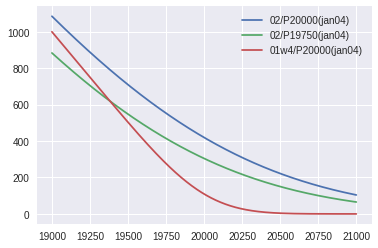

In [4]:
# sample base graph
x = np.arange(19000, 21000)
setting(20250, 26, 20190124)
for s in ['02/P20000', '02/P19750', '01w4/P20000']:
    plt.plot(x, np.vectorize(Option(s).v)(x), label=s + '(jan04)')
plt.legend(loc="best")
